#### Fraud Detection model using AutoML on AWS Sagemaker

## 1. Importing the data

The dataset we have contains credit card transactions from Europen Cardholders in the year 2013.

As with all such datasets , it is highly imbalanced dataset making it difficult to find patterns of frauds.

There are only 492 Fraudulent transactions among approximately 284800 transactions. The dataset has only numerical features obtained after using PCA.

It helps by hiding the confidential data.
The dataset only contains 28 PCA components with 2 features not altered , Time and Amount.
Amount refers to the transactions amount and time refers to the time eplased between any transaction and the first transaction in seconds.


Source - "https://github.com/jbrownlee/Datasets"

Lets start by importing the data and unzipping the file

In [3]:
%%bash
wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/creditcard.csv.zip
unzip creditcard.csv.zip

Archive:  creditcard.csv.zip
  inflating: creditcard.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._creditcard.csv  


--2021-12-10 01:52:37--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/creditcard.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68787176 (66M) [application/zip]
Saving to: ‘creditcard.csv.zip’

     0K .......... .......... .......... .......... ..........  0% 69.3M 1s
    50K .......... .......... .......... .......... ..........  0%  116M 1s
   100K .......... .......... .......... .......... ..........  0% 75.6M 1s
   150K .......... .......... .......... .......... ..........  0% 88.2M 1s
   200K .......... .......... .......... .......... ..........  0%  174M 1s
   250K .......... .......... .......... .......... ..........  0%  219M 1s
   300K .......... .......... .......... .......... ..........  0%  216M 1s
   350K ..........

In [4]:
# Importing the neccesary libraries as and when needed.
import pandas as pd

# reading the csv file obtained.

input_csv = pd.read_csv("creditcard.csv",names=['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'])

# We will be taking only 100000 samples out of 284800 as input.
input_csv = input_csv.sample(n=100000)

# Initial look up at the table to get an idea how the data looks annd looking for some discrepancies.
input_csv.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
124916,77471.0,1.208979,0.176456,-0.038631,0.230011,0.167064,-0.325209,0.264019,-0.124005,-0.444907,...,-0.469300,-1.493175,0.103200,-0.508589,0.170985,0.003063,-0.057579,0.007417,44.95,0
111380,72209.0,-2.355663,-1.062768,2.881997,1.612670,-0.239989,1.462987,-1.756041,1.441738,0.836500,...,0.402174,1.111211,-0.222708,-0.210299,0.335265,0.064117,0.339849,-0.143154,58.00,0
135638,81336.0,1.253596,0.232190,-0.091524,0.946319,0.077062,-0.487822,0.207207,-0.163356,0.098120,...,-0.016776,-0.074347,-0.220452,-0.452818,0.776564,-0.277749,0.005163,0.015453,30.00,0
209787,137708.0,1.129706,-1.207823,-2.350405,1.656583,0.024243,-1.347598,1.436114,-0.634697,-0.126660,...,0.410381,0.167882,-0.434681,0.056208,0.275236,-0.536987,-0.127507,0.020262,491.10,0
50618,44569.0,-0.434785,0.872972,0.455299,0.869779,-0.373575,-0.220424,0.479959,0.453247,-0.829709,...,0.243074,0.391035,0.101452,-0.027277,-0.115668,-0.324329,-0.083579,-0.027549,94.40,0


In [5]:
# importing datetime module to get the time from sys
import datetime as dt

# Adding 2 fields which is required to track version and uniquely identify records when using feature store
# for that adding event_time which will take the current time as value and record id which should be unique is "index+1"
input_csv["event_time"] =dt.datetime.now()
input_csv["record_id"] = input_csv.index + 1

input_csv.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,amount,class,event_time,record_id
124916,77471.0,1.208979,0.176456,-0.038631,0.230011,0.167064,-0.325209,0.264019,-0.124005,-0.444907,...,0.103200,-0.508589,0.170985,0.003063,-0.057579,0.007417,44.95,0,2021-12-10 01:52:43.962860,124917
111380,72209.0,-2.355663,-1.062768,2.881997,1.612670,-0.239989,1.462987,-1.756041,1.441738,0.836500,...,-0.222708,-0.210299,0.335265,0.064117,0.339849,-0.143154,58.00,0,2021-12-10 01:52:43.962860,111381
135638,81336.0,1.253596,0.232190,-0.091524,0.946319,0.077062,-0.487822,0.207207,-0.163356,0.098120,...,-0.220452,-0.452818,0.776564,-0.277749,0.005163,0.015453,30.00,0,2021-12-10 01:52:43.962860,135639
209787,137708.0,1.129706,-1.207823,-2.350405,1.656583,0.024243,-1.347598,1.436114,-0.634697,-0.126660,...,-0.434681,0.056208,0.275236,-0.536987,-0.127507,0.020262,491.10,0,2021-12-10 01:52:43.962860,209788
50618,44569.0,-0.434785,0.872972,0.455299,0.869779,-0.373575,-0.220424,0.479959,0.453247,-0.829709,...,0.101452,-0.027277,-0.115668,-0.324329,-0.083579,-0.027549,94.40,0,2021-12-10 01:52:43.962860,50619


Now we need to upload the file to S3 bucket which is object storage service for using later on.

Installing the latest sagemaker python sdk

In [6]:
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached sagemaker-2.70.0-py2.py3-none-any.whl
     |████████████████████████████████| 131 kB 36.7 MB/s            
     |████████████████████████████████| 8.4 MB 59.9 MB/s            
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.4
    Uninstalling botocore-1.23.4:
      Successfully uninstalled botocore-1.23.4
  Attempting uninstall: boto3
    Found existing installation: boto3 1.20.4
    Uninstalling boto3-1.20.4:
      Successfully uninstalled boto3-1.20.4
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.68.0
   

In [7]:
#Importing the sagemaker module
import sagemaker


#Initiating the sagamaker session.
session = sagemaker.Session()

# Writint to csv in S3 without index column because we dont need the index column.
input_csv.to_csv('credit-dataset.csv',index=False)

# "upload_data" method in sagemaker helps us uplaoding the file to object storage service.
# the key_prefix parameter defines the path inside the bucket.
inputs = session.upload_data(path='credit-dataset.csv', key_prefix='data/fraud-detection')
display(inputs)



's3://sagemaker-ap-south-1-080451317723/data/fraud-detection/credit-dataset.csv'

Now we can see that the file has been added and the path to our csv file on S3 which is accessible for this sagemaker session.

# Setup for sagemaker session

In [8]:
# importing boto3 
# It is python package helps in managing AWS resources such as S3 and EC2
import boto3 

#For sagemaker, proper role implementation is required in the IAM policies
from sagemaker import get_execution_role

#for confirming the latest version
print(sagemaker.__version__)

# fetching the region of this sagemaker session.
region = boto3.Session().region_name
print("region is ",region)

#Creating a default buckert which will store all the data during this session. Note that it should be in the same region.
bucket = session.default_bucket()
#sepcifying the path
prefix="sagemaker/fraud-autopilot"

#initialising the variable with the role assigned.
role = get_execution_role()
print("SageMaker Role : ",role)

#accessing the sagemaker services
sm = boto3.Session().client(service_name='sagemaker',region_name=region)




2.70.0
region is  ap-south-1
SageMaker Role :  arn:aws:iam::080451317723:role/service-role/AmazonSageMaker-ExecutionRole-20211126T134068


Importing the required libraries beforehand.



In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import AutoML
from time import gmtime,strftime,sleep
from pprint import pprint
import json
import io
from urllib.parse import urlparse
from sklearn.metrics import (
roc_auc_score,roc_curve,precision_recall_curve,classification_report,average_precision_score,precision_score,recall_score)



### Inspecting the Dataset before using is a good practice as it will help us avoid errors during training.

In [10]:
#creating a boto session object for accessing the S3 bucket we have our file inside. 
s3_client = boto3.Session().client(service_name='s3',region_name=region)

#initialising the variable for default bucket 
fraud_detection_bucket_name = bucket

#path to our dataset
data_file_key = 'data/fraud-detection/credit-dataset.csv'

#fetching the file
data_object=s3_client.get_object(Bucket=fraud_detection_bucket_name,Key=data_file_key)

#reading the contents of the file. This is slightly differnt from usual because the file is stored as object in S3.
transaction_data = pd.read_csv(io.BytesIO(data_object['Body'].read()))
transaction_data = transaction_data[['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class']]

#verifying the data
transaction_data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,77471.0,1.208979,0.176456,-0.038631,0.230011,0.167064,-0.325209,0.264019,-0.124005,-0.444907,...,-0.469300,-1.493175,0.103200,-0.508589,0.170985,0.003063,-0.057579,0.007417,44.95,0
1,72209.0,-2.355663,-1.062768,2.881997,1.612670,-0.239989,1.462987,-1.756041,1.441738,0.836500,...,0.402174,1.111211,-0.222708,-0.210299,0.335265,0.064117,0.339849,-0.143154,58.00,0
2,81336.0,1.253596,0.232190,-0.091524,0.946319,0.077062,-0.487822,0.207207,-0.163356,0.098120,...,-0.016776,-0.074347,-0.220452,-0.452818,0.776564,-0.277749,0.005163,0.015453,30.00,0
3,137708.0,1.129706,-1.207823,-2.350405,1.656583,0.024243,-1.347598,1.436114,-0.634697,-0.126660,...,0.410381,0.167882,-0.434681,0.056208,0.275236,-0.536987,-0.127507,0.020262,491.10,0
4,44569.0,-0.434785,0.872972,0.455299,0.869779,-0.373575,-0.220424,0.479959,0.453247,-0.829709,...,0.243074,0.391035,0.101452,-0.027277,-0.115668,-0.324329,-0.083579,-0.027549,94.40,0


#### Division of data. Here we are dividing the data into 2 parts. Train and test.
Train data will be used by autopilot to learn and test data will be used to obtain inferences from the suggested model.




In [11]:
# 80% data at random is chosen as train data. 
# Randomising is important because picking data in a particular fashion can create bias in the model especially in tim series data.
train_data = transaction_data.sample(frac = 0.8,random_state =200)

# test data which has index column being dropped
test_data =transaction_data.drop(train_data.index)

# We remove the target column from the test data to measure the results of the inferences
test_data_no_target= test_data.drop(columns=['class'])



Saving the Train/Test split into separate csv files.

In [12]:
# header is included as it denotes the column name
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=True)

test_file = "test_data.csv"
test_data_no_target.to_csv(test_file, index=False, header=False)

### AutoML pilot job configuration

Using the 'AutoMl' estimator to invoke Autopilot to find the best ML pipeline to train the model for this specific dataset.

Inputs required->
1. S3 location for input dataset(train data)
2. Target column ( column that we want to predict, which is class in our case)
3. IAM role to give proper permissions.



In [13]:
# obtaining the current time stamp to be added in front of job name for unique identification
timestamp_suffix = strftime("%d-%H-%M-%S",gmtime())
print(timestamp_suffix)

base_job_name = "automl-fraud-" +timestamp_suffix

#specifying the column name to be predicted
target_attribute_name = "class"

# here we obtain the unique values in the prediction column. 
# It will have 2 values for binary classification and mulitple values for multiclass classiiication.
target_attribute_values = np.unique(train_data[target_attribute_name])

# Specifying the true value 
target_attribute_true_value = target_attribute_values[1]

# Invoking the AutoML function
# candiates here refers to the "pipeline evaluations it will execute"
# generally for large and significantly important dataset we can put this number higher, but it means consuming lots of computing power and time.
automl = AutoML(role=role,
               target_attribute_name=target_attribute_name,
               base_job_name=base_job_name,
               sagemaker_session=session,
               max_candidates=3
               )

10-01-53-05


### Initiating the Job

In [14]:
# launching the job using fit method
automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

In [15]:
### Tracking the progress



In [16]:
print("JobStatus - Secondary Status")
print("------------------------------")

# function to access the progress of automl job
describe_response = automl.describe_auto_ml_job()
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])

job_run_status = describe_response["AutoMLJobStatus"]

# Looping in every 30 seconds to check the status of our job just to be sure that everything is going on fine.
while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(30) 

JobStatus - Secondary Status
------------------------------
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureE

In [17]:
# just for information purposes , these are all the parameters we can check during the automl job.
all_info=automl.describe_auto_ml_job()
print(all_info)

{'AutoMLJobName': 'automl-fraud-10-01-53-05', 'AutoMLJobArn': 'arn:aws:sagemaker:ap-south-1:080451317723:automl-job/automl-fraud-10-01-53-05', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-ap-south-1-080451317723/auto-ml-input-data/train_data.csv'}}, 'TargetAttributeName': 'class'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-ap-south-1-080451317723/'}, 'RoleArn': 'arn:aws:iam::080451317723:role/service-role/AmazonSageMaker-ExecutionRole-20211126T134068', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 3}, 'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}}, 'CreationTime': datetime.datetime(2021, 12, 10, 1, 53, 5, 983000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2021, 12, 10, 2, 25, 34, 190000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2021, 12, 10, 2, 25, 34, 218000, tzinfo=tzlocal()), 'BestCandidate': {'CandidateName': 'automl-fraud-10-01-53-05tKLpnOsC-003-c089661a',

In [18]:
# describing the Best Candidate which performed best on training data
best_candidate = automl.describe_auto_ml_job()["BestCandidate"]

#best candidate name
best_candidate_name = best_candidate["CandidateName"]
pprint(best_candidate)

print("\n")
print("CandidateName: " + best_candidate_name)

#Printing all the metrics of the Best candidate
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)

{'CandidateName': 'automl-fraud-10-01-53-05tKLpnOsC-003-c089661a',
 'CandidateProperties': {'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-ap-south-1-080451317723/automl-fraud-10-01-53-05/documentation/explainability/output'},
                         'CandidateMetrics': [{'MetricName': 'F1',
                                               'Set': 'Validation',
                                               'Value': 0.8571400046348572},
                                              {'MetricName': 'AUC',
                                               'Set': 'Validation',
                                               'Value': 0.9548900127410889},
                                              {'MetricName': 'Accuracy',
                                               'Set': 'Validation',
                                               'Value': 0.9995599985122681}]},
 'CandidateStatus': 'Completed',
 'CandidateSteps': [{'CandidateStepArn': 'arn:aws:sagemaker:ap-south-1:080451

In [19]:
TOP_N_CANDIDATES=1  # number of top candidates to check

In [20]:
# checking all the list of candidates
candidates = automl.list_candidates(
    sort_by="FinalObjectiveMetricValue", sort_order="Descending", max_results=TOP_N_CANDIDATES
)

for candidate in candidates:
    print("Candidate name: ", candidate["CandidateName"])
    print("Objective metric name: ", candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"])
    print("Objective metric value: ", candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    print("\n")

Candidate name:  automl-fraud-10-01-53-05tKLpnOsC-003-c089661a
Objective metric name:  validation:f1_binary
Objective metric value:  0.8571400046348572




## Evaluating Top Candidates for our test data

### Uploading the Data for Batch Transform Job

Using the Test data file stored in S3 bucket.


In [21]:
test_data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
3,137708.0,1.129706,-1.207823,-2.350405,1.656583,0.024243,-1.347598,1.436114,-0.634697,-0.126660,...,0.410381,0.167882,-0.434681,0.056208,0.275236,-0.536987,-0.127507,0.020262,491.1,0
4,44569.0,-0.434785,0.872972,0.455299,0.869779,-0.373575,-0.220424,0.479959,0.453247,-0.829709,...,0.243074,0.391035,0.101452,-0.027277,-0.115668,-0.324329,-0.083579,-0.027549,94.4,0
14,19910.0,1.413851,-0.571332,0.285630,-0.560176,-0.625381,0.029696,-0.821906,0.001137,0.767398,...,-0.186685,-0.270310,-0.130412,-0.579424,0.591721,-0.244295,-0.023304,-0.013810,10.0,0
17,74843.0,-1.051053,-0.523024,3.128005,-1.152076,-1.426727,0.423105,-0.745015,0.515976,-0.050889,...,-0.448937,-0.471210,-0.097296,0.579890,0.170725,0.987676,0.265402,0.121845,40.0,0
23,69861.0,-0.290012,0.797643,1.609420,0.546492,0.378429,-0.579977,0.950458,-0.244217,-0.436078,...,0.109125,0.479940,-0.172948,0.401629,0.111783,-0.387526,-0.114515,-0.194930,15.0,0


In [22]:
#uploading the transform data set input into s3 bucket
input_data_transform = session.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
print("Uploaded transform data to {}".format(input_data_transform))

Uploaded transform data to s3://sagemaker-ap-south-1-080451317723/sagemaker/fraud-autopilot/test_data.csv


In [23]:
# using the "predicted_label" for predicted class and probability to check out the probability of model predicting the class as True.
inference_response_keys = ["predicted_label", "probability"]

In [24]:
### Creating Models and Tranform Estimators


In [25]:
#inititalising a s3 bucket to store the output path for our inferences.
s3_transform_output_path = "s3://{}/{}/inference-results/".format(bucket, prefix)

# empty transformers list
transformers = []

#looping in all the candidates and creating a transform estimator model.
for candidate in candidates:
    model = automl.create_model(
        name=candidate["CandidateName"],
        candidate=candidate,
        inference_response_keys=inference_response_keys,
    )

    output_path = s3_transform_output_path + candidate["CandidateName"] + "/"

    transformers.append(
        model.transformer(
            instance_count=1,
            instance_type="ml.m5.xlarge",
            assemble_with="Line",
            output_path=output_path,
        )
    )
print("Setting up {} Batch Transform Jobs in `transformers`".format(len(transformers)))

Setting up 1 Batch Transform Jobs in `transformers`


### Start the Transform Job




In [26]:
# earlier we initiased the transform list with all the parameters required.
# we are here starting the tranform job on our test data.
for transformer in transformers:
    transformer.transform(
        data=input_data_transform, split_type="Line", content_type="text/csv", wait=False
    )
    print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job automl-fraud-10-01-53-05tKLpnOsC-003-c0-2021-12-10-02-26-14-794


### Tracking transform batch progress

In [27]:
# Checking the status of the transform job
pending_complete = True

while pending_complete:
    pending_complete = False
    num_transform_jobs = len(transformers)
    for transformer in transformers:
        desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
        if desc["TransformJobStatus"] not in ["Failed", "Completed"]:
            pending_complete = True
        else:
            num_transform_jobs -= 1
    print("{} out of {} transform jobs are running.".format(num_transform_jobs, len(transformers)))
    sleep(30)

for transformer in transformers:
    desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    print(
        "Transform job '{}' finished with status {}".format(
            transformer._current_job_name, desc["TransformJobStatus"]
        )
    )

1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
0 out of 1 transform jobs are running.
Transform job 'automl-fraud-10-01-53-05tKLpnOsC-003-c0-2021-12-10-02-26-14-794' finished with status Completed


## Evaluating the final inference results

Now we analyze our inference results. The batch transform results are stored in S3. So we define a helper method to get the results from S3.

In [28]:
import json
import io
from urllib.parse import urlparse

# our inferences are stored in S3 
# function to fetch the results from S3

def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [29]:
# empty predictions list
predictions = []

for transformer in transformers:
    print(transformer.output_path)
    pred_csv = get_csv_from_s3(transformer.output_path, "{}.out".format(test_file))
    predictions.append(pd.read_csv(io.StringIO(pred_csv), header=None))

s3://sagemaker-ap-south-1-080451317723/sagemaker/fraud-autopilot/inference-results/automl-fraud-10-01-53-05tKLpnOsC-003-c089661a/


# Analysing the Predition Results



In [30]:
# Using various metrics from sklearn library
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score,
)
import matplotlib.pyplot as plt

labels = test_data[target_attribute_name].apply(
    lambda row: True if row == target_attribute_true_value else False
)

# calculating auc score
for prediction, candidate in zip(predictions, candidates):
    roc_auc = roc_auc_score(labels, prediction.loc[:, 1])
    ap = average_precision_score(labels, prediction.loc[:, 1])
    print(
        "%s's ROC AUC = %.2f, Average Precision = %.2f" % (candidate["CandidateName"], roc_auc, ap)
    )
    print(classification_report(test_data[target_attribute_name], prediction.loc[:, 0]))
    print()

automl-fraud-10-01-53-05tKLpnOsC-003-c089661a's ROC AUC = 0.97, Average Precision = 0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19962
           1       0.94      0.82      0.87        38

    accuracy                           1.00     20000
   macro avg       0.97      0.91      0.94     20000
weighted avg       1.00      1.00      1.00     20000




Plotting the ROC curve for easy visualisation.

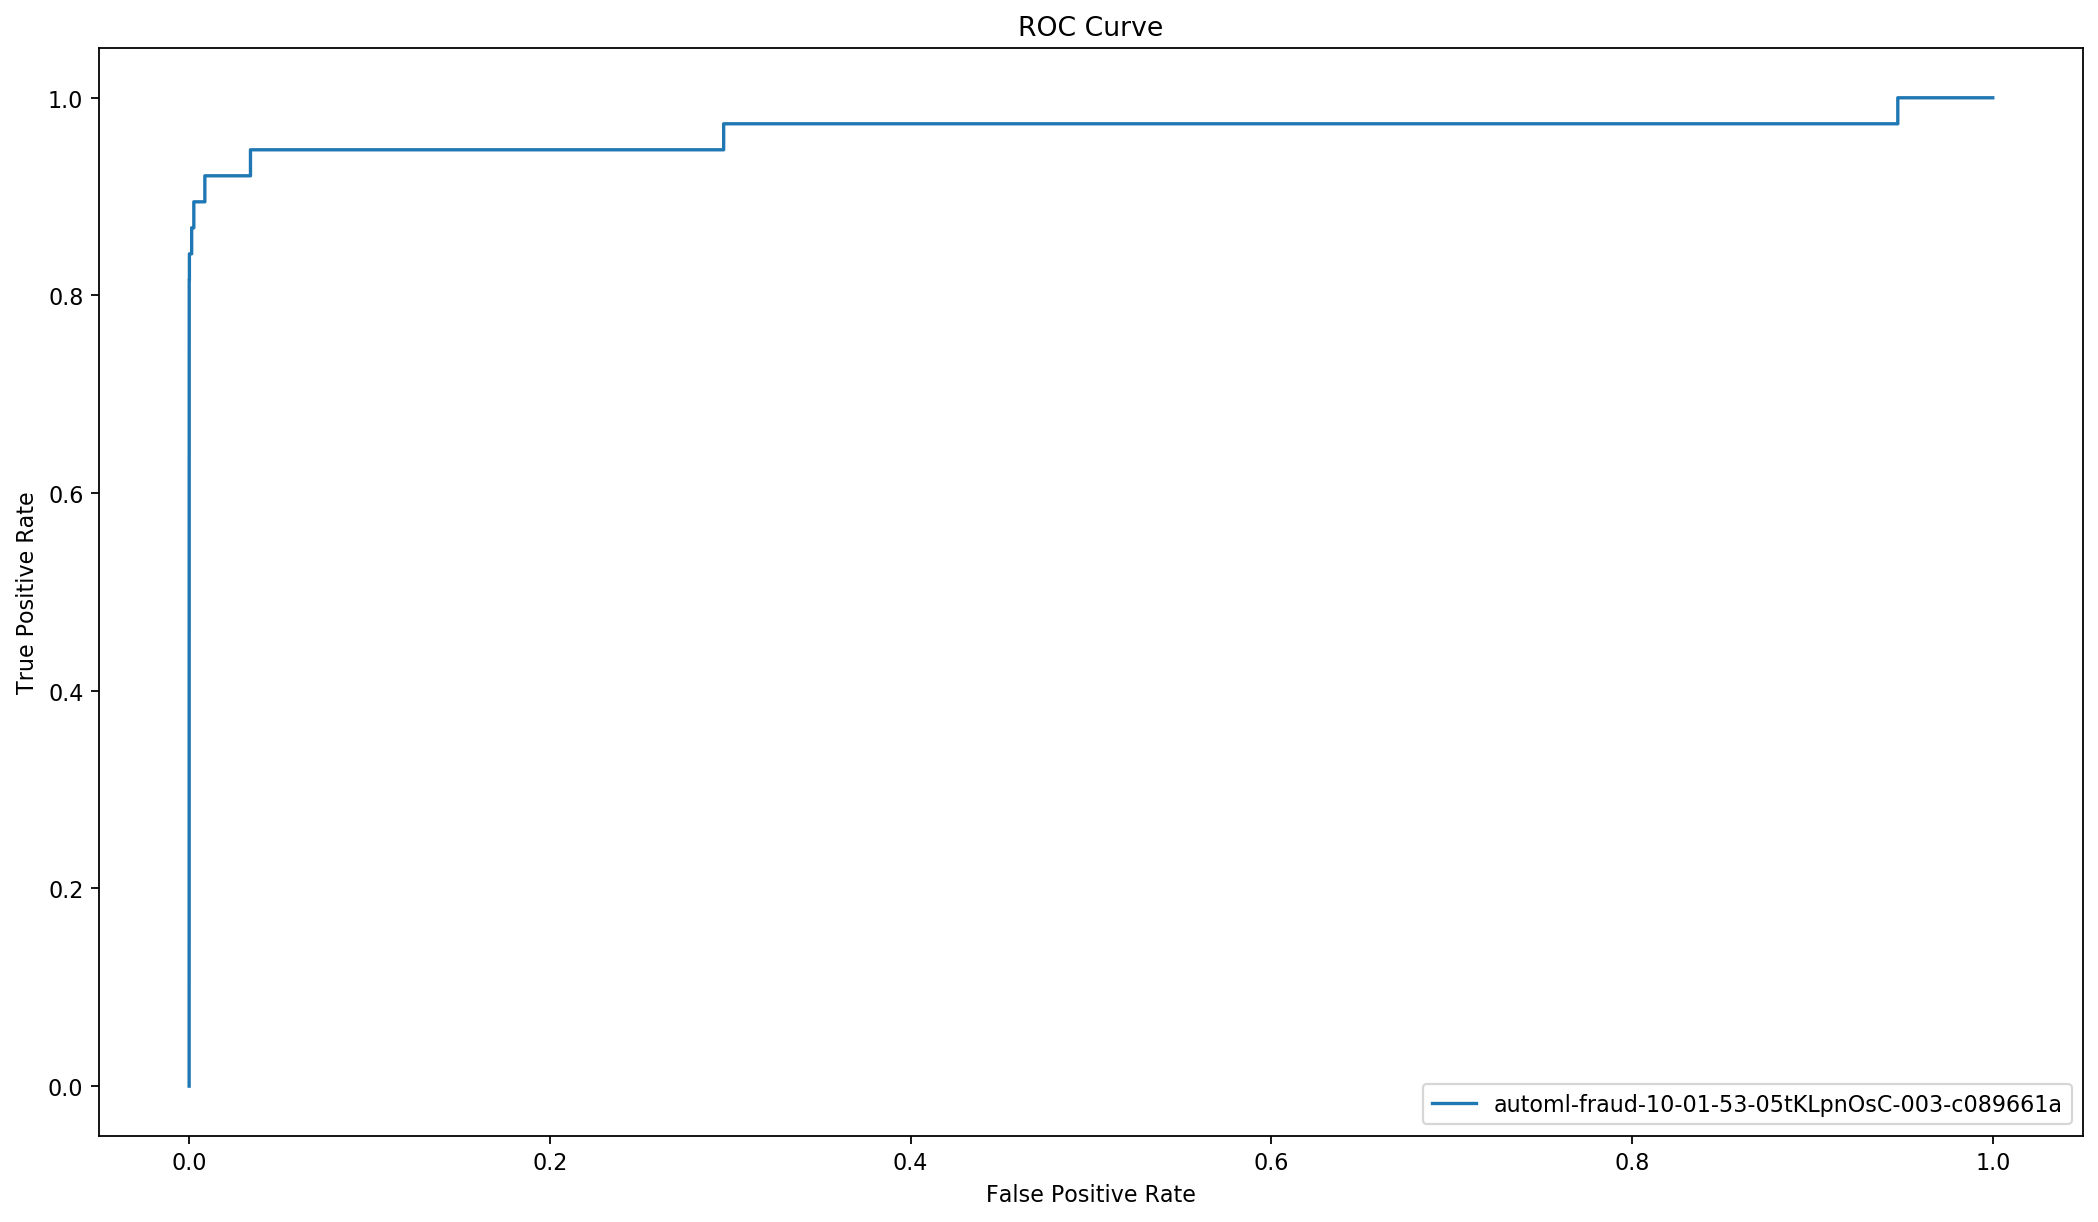

In [31]:
#false_positive_rate_true_positive_rate list 
fpr_tpr = []
for prediction in predictions:
    fpr, tpr, _ = roc_curve(labels, prediction.loc[:, 1])
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

# plotting ROC curve 
plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*fpr_tpr)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Plotting the precision-recall curve.

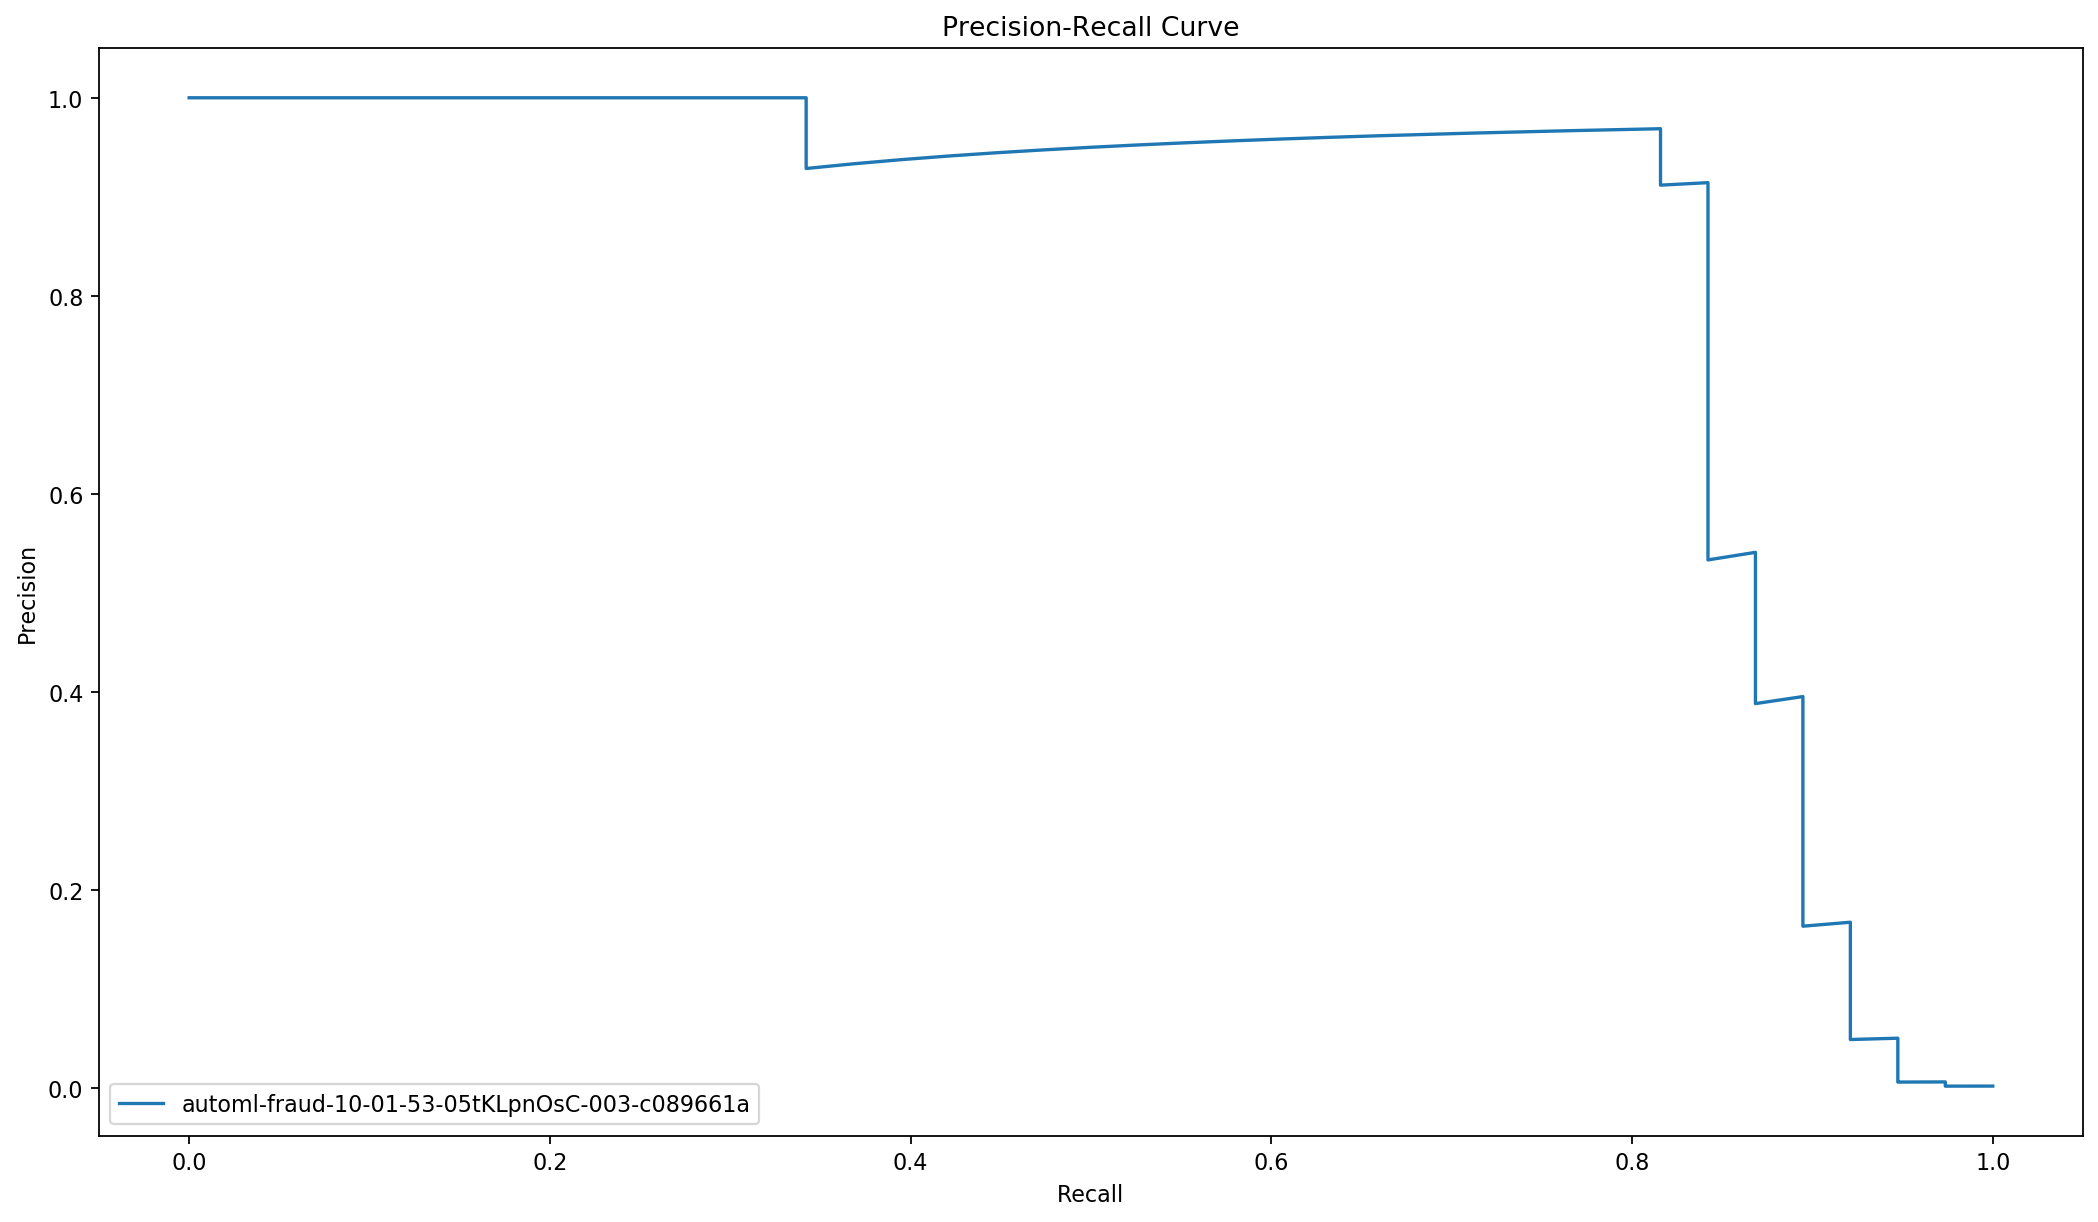

In [32]:
# precision_recall list
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(labels, prediction.loc[:, 1])
    precision_recall.append(recall)
    precision_recall.append(precision)


plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*precision_recall)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower left")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

We are expected to have a minimal target precision for our model to be good enough since , no model is perfect. So considering that we will find the model that returns the best recall and operation parameters.
Given the target minimal precision, we will find the model that provides the best recall and the operation point for that model.

In [33]:
#setting the target minimal precision
target_min_precision = 0.75

# best recall
best_recall = 0

# initialising the candidate index variable 
best_candidate_idx = -1
best_candidate_threshold = -1
candidate_idx = 0
for prediction in predictions:
    precision, recall, thresholds = precision_recall_curve(labels, prediction.loc[:, 1])
    threshold_idx = np.argmax(precision >= target_min_precision)
    if recall[threshold_idx] > best_recall:
        best_recall = recall[threshold_idx]
        best_candidate_threshold = thresholds[threshold_idx]
        best_candidate_idx = candidate_idx
    candidate_idx += 1

print("Best Candidate Name: {}".format(candidates[best_candidate_idx]["CandidateName"]))
print("Best Candidate Threshold (Operation Point): {}".format(best_candidate_threshold))
print("Best Candidate Recall: {}".format(best_recall))

Best Candidate Name: automl-fraud-10-01-53-05tKLpnOsC-003-c089661a
Best Candidate Threshold (Operation Point): 0.099430114030838
Best Candidate Recall: 0.8421052631578947


obtaining predictions of the best model based on the selected operating point.

In [34]:
prediction_default = predictions[best_candidate_idx].loc[:, 0] == target_attribute_true_value
prediction_updated = predictions[best_candidate_idx].loc[:, 1] >= best_candidate_threshold

# compare the updated predictions to Autopilot's default
from sklearn.metrics import precision_score, recall_score

print(
    "Default Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_default), precision_score(labels, prediction_default)
    )
)
print(
    "Updated Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_updated), precision_score(labels, prediction_updated)
    )
)

Default Operating Point: recall=0.8157894736842105, precision=0.9393939393939394
Updated Operating Point: recall=0.8421052631578947, precision=0.7619047619047619


Here we see that the default operating point had recall =.80 and a very high precision above our threshold, And the updated operating point had recall= .84 but a low precision.
Since our model had balanced precision more than threshold and a decent recall, we can consider the feault model a good fit for deployment.

In [35]:
## Cleanup 




In [36]:
# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

Finally, we delete the models and the endpoint.

In [37]:
# for transformer in transformers:
#     transformer.delete_model()

